# Combine Survey Data
2017-06-26 
MJ Rose, with scripts from Joe Callingham

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import Image, display
from IPython.display import Javascript
import numpy as np
import os, glob, subprocess, time, psutil, sys, shutil, fnmatch
import pandas as pd
from mirpy import miriad 
# note: mirpy is a python2 module that I futurized
# so I could use it in python3


# Joe's SED plotting 
import seds_plot_func
from gpscssmodels import *

# my own
from reduction_funcs import *


import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.optimize as opt
import scipy.stats as stats
from astropy.io import fits
import sys
import scipy.special as special # For access to the incomplete gamma function.
import emcee
import triangle 
import inspect

sedfile = 'sed_df.pkl'
sed_loc = os.getcwd()+"/"+sedfile

In [6]:
class Survey(object):
    def __init__(self, name, freq, flux_id, flux_err_coeff, flux_scale):
        self.name = name
        self.freq = freq
        self.flux_id = flux_id
        self.flux_err_coeff = flux_err_coeff
        self.flux_scale = flux_scale
    def flux(self, raw_flux_value):
        return(raw_flux_value*self.flux_scale)
    def flux_err(self,raw_flux_value):
        if not isinstance(self.flux_err_coeff, float):
            return(['look in {0} and scale by {1}'.format(self.flux_err_coeff, self.flux_scale),self.flux_err_coeff, self.flux_scale] )
        else:
            return(raw_flux_value*self.flux_scale*self.flux_err_coeff)

        
# double check the scalings        
surveys = [Survey('VLSSr', 0.074, "PEAK INT_1", 0.1, 1), Survey('TGSS', 0.148, "Total_flux", 'E_Total_flux', 10**(-3)), 
           Survey('MRC', 0.408, 'S408', 0.1, 1), Survey('SUMSS', 0.843, "St", 0.05, 10**(-3)), 
           Survey('NVSS', 1.40, "PEAK INT_2", 0.05, 1), Survey('ATPMN', 4.85, "S5_1", 0.1, 10**(-3)),
           Survey('ATPMN', 8.64, 'S8_1', 0.1, 10**(-3)), Survey('AT20G', 19.904001, 'S20', 0.05, 10**(-3)),
           Survey('AT20G_8', 8.641001, 'S8_2', 0.05, 10**(-3)),Survey('AT20G_5', 4.8001, 'S5_2', 0.05, 10**(-3))]
ATCA_err = 0.05

## collect data from various files

In [84]:
# path to ATCA reduced data
uvfmeas_paths = []
for p in ["/Volumes/mjrose/C3030/"]:
    path = p
    regex = 'uvfmeaslog*'
    uvfmeas_paths.extend(recursive_glob(path, regex))

# path to matched gleam and friends table
gleam = "/Users/mmcintosh/Dropbox/ASTRON2017/C3030/survey_data/gleam_and_friends.csv" #supermatched.csv"
df = pd.read_csv(gleam, sep=",")
# get rid of blank rows
df = df.dropna(0, 'all')
df = df.dropna(subset=['ID'])
for i in df.index.tolist():
    df.set_value(i,'ID',''.join(df.loc[i]['ID'].split()).lower())
    
    

# get rid of repeated entries
for i in df.index.tolist():
    # find all rows that have similar IDs
    try:
        name = df.loc[i].ID
    except:
        continue

    possible_IDs = np.unique([name.split('pks')[-1], name.split('mwacsj')[-1], name])
    
    repeats = []
    for t in possible_IDs:
        repeats.extend([a for a,b in enumerate(df.ID) if t in b])
    
    repeats = np.unique(repeats)
    
    # from the repeated IDs, pick out the longest name to keep
    # ID_tokeep = max(df.loc[repeats].ID, key=len)
    # set ID to array of possible IDs

    # combine repeated rows into one new row
    new_entry = pd.concat([df.loc[j].dropna() for j in repeats])
    duplicate_entries = new_entry[new_entry.index.duplicated()].index
    for entry in duplicate_entries:
        dupes = new_entry[entry].values
        new_entry = new_entry.drop(entry)
        new_entry[entry] = dupes
    
    
    # remove old repeated rows
    df = df.drop(df.index[repeats])
    
    # add in the new combined row
    df = df.append(new_entry, ignore_index=True)

    

# get column names for gleam data
colnames = [s for s in list(df) if "err_int_flux" in s]
#print(colnames)
# ok, so all but the first and last
colnames = colnames[1:-1]
#print(colnames)

# new df to write results to 
sed_df = pd.DataFrame({'name' : df.ID.values, 'freq': '', 'flux':'', 'flux_err':'', 'best_model':''})

# for each name, make an array of freq, flux
counter = 0 
missing_uv = []
for i in df.index.tolist():
    
    # find uvfmeas data 
    uvfmeas_freq_arr = []
    uvfmeas_freq_err_arr = []
    uvfmeas_flux_arr = []
    uvfmeas_flux_err_arr = []
        
    name = df.loc[i].ID
    if not isinstance(name, str):
        name = name[0]
    
    # check a couple different versions of the name
    
    try:
        path = [s for s in uvfmeas_paths if name in s]
        if path == []:
            path = [s for s in uvfmeas_paths if name.split('pks')[-1] in s]
        if path == []:
            path = [s for s in uvfmeas_paths if name.split('mwacsj')[-1] in s]
        if path == []:
            path = [s for s in uvfmeas_paths if name.split('mwacsj')[-1].split('-')[0] in s]
        if path == []:
            missing_uv.append(i)
            counter +=1
            
            
        
        for p in sorted(path):
            temp = np.genfromtxt(p)
            temp = list(zip(*temp))
            temp_freq_arr = temp[0]
            temp_flux_arr = temp[1]
            temp_flux_err_arr = [f*ATCA_err for f in temp_flux_arr]
            temp_freq_err_arr = np.repeat(0, len(temp_freq_arr))
            #print(np.max(temp_freq_arr), np.min(temp_freq_arr))

            uvfmeas_freq_arr.extend(temp_freq_arr)
            uvfmeas_freq_err_arr.extend(temp_freq_err_arr)
            uvfmeas_flux_arr.extend(temp_flux_arr)
            uvfmeas_flux_err_arr.extend(temp_flux_err_arr)
        
    except:
        print('no ufvmeas data for {0}'.format(name))

        
        
    # find the singular survey points

    survey_flux_arr = []
    survey_flux_err_arr = []
    survey_freq_arr = []
    for survey in surveys: 
        rawflux = df.loc[i][survey.flux_id]
        if isinstance(rawflux, np.ndarray):
            print('duplicate error with {0}'.format(name))
            for j in np.arange(len(rawflux)):
                if not np.isnan(rawflux[j]):
                    flux = survey.flux(rawflux[j])
                    freq = survey.freq
                    flux_err = survey.flux_err(rawflux[j])
                    if not isinstance(flux_err, float):
                        flux_err = df.loc[i][flux_err[1]]*flux_err[2]
                    #print(survey.name + " with freq {1} has a flux of {0}".format(flux, freq))

                    survey_flux_arr.append(flux)
                    survey_flux_err_arr.append(flux_err)
                    survey_freq_arr.append(freq)    
                
        else:   
            if not np.isnan(rawflux):
                flux = survey.flux(rawflux)
                freq = survey.freq
                flux_err = survey.flux_err(rawflux)
                if not isinstance(flux_err, float):
                    flux_err = df.loc[i][flux_err[1]]*flux_err[2]
                #print(survey.name + " with freq {1} has a flux of {0}".format(flux, freq))

                survey_flux_arr.append(flux)
                survey_flux_err_arr.append(flux_err)
                survey_freq_arr.append(freq)    

    # find gleam catalog data

    gleam_freq_arr = []
    gleam_freq_err_arr = []
    gleam_flux_err_arr = []
    gleam_flux_arr = []


    for col in colnames: 

        # skip over data that is too noisy
        flux = df.loc[i][col.split('err_')[-1]]
        rms = df.loc[i]['local_rms_'+col.split('_')[-1]]
        if isinstance(flux, np.ndarray):
            for f in np.arange(len(flux)): 
                
                snr = flux[f]/rms[f]
                if snr >= 3.0:

                    gleam_freq_arr.append(float("0."+col.split("_")[-1]))
                    #gleam_freq_err_arr.append(0)

                    gleam_flux_arr.append(f)

                    err = np.sqrt((df.loc[i][col][f])**2 + \
                    (df.loc[i][col.split('err_')[-1]][f]* df.loc[i]['err_abs_flux_pct'][f]*10**(-2) ) **2 )
                    gleam_flux_err_arr.append(err) 
                
        else:
            snr = flux/rms
            if snr >= 3.0:

                gleam_freq_arr.append(float("0."+col.split("_")[-1]))
                #gleam_freq_err_arr.append(0)

                gleam_flux_arr.append(flux)

                err = np.sqrt((df.loc[i][col])**2 + \
                (df.loc[i][col.split('err_')[-1]]* df.loc[i]['err_abs_flux_pct']*10**(-2) ) **2 )
                gleam_flux_err_arr.append(err) 


    # append all

    '''freq_arr = np.concatenate([uvfmeas_freq_arr, survey_freq_arr, gleam_freq_arr[::-1]], axis=0)
    #freq_err_arr = np.concatenate([uvfmeas_freq_err_arr, gleam_freq_err_arr[::-1]], axis=0)
    flux_arr = np.concatenate([uvfmeas_flux_arr, survey_flux_arr, gleam_flux_arr[::-1]],axis=0)
    flux_err_arr = np.concatenate([uvfmeas_flux_err_arr, survey_flux_err_arr, gleam_flux_err_arr[::-1]],axis=0)'''


    freq_arr = np.concatenate([uvfmeas_freq_arr, survey_freq_arr, gleam_freq_arr], axis=0)
    flux_arr = np.concatenate([uvfmeas_flux_arr, survey_flux_arr, gleam_flux_arr],axis=0)
    flux_err_arr = np.concatenate([uvfmeas_flux_err_arr, survey_flux_err_arr, gleam_flux_err_arr],axis=0)

    # add to df
    sed_df.set_value(i, 'flux', flux_arr) 
    sed_df.set_value(i, 'flux_err', flux_err_arr) 
    sed_df.set_value(i, 'freq', freq_arr) 
    #sed_df.set_value(i, 'freq_err', freq_err_arr) 

    
# don't keep matches for sources without ATCA data    
#sed_df.drop(sed_df.index[missing_uv], inplace=True)
#sed_df.reset_index(drop=True, inplace=True)    
    
# save df for next time
sed_df.to_pickle(sed_loc)
    
print('ufvmeas data found for {0}/{1} of your sources'.format(len(df) - counter, len(df)))

ufvmeas data found for 79/127 of your sources


In [87]:
# path to matched gleam and friends table
gleam = "/Users/mmcintosh/Dropbox/ASTRON2017/C3030/survey_data/gleam_and_friends.csv" #supermatched.csv"
df = pd.read_csv(gleam, sep=",")
# get rid of blank rows
df = df.dropna(0, 'all')
df = df.dropna(subset=['ID'])
for i in df.index.tolist():
    df.set_value(i,'ID',''.join(df.loc[i]['ID'].split()).lower())
    

In [91]:
[col for col in df.columns]

['Name',
 'background_wide',
 'local_rms_wide',
 'ra_str',
 'dec_str',
 'RAJ2000',
 'err_RAJ2000',
 'DEJ2000',
 'err_DEJ2000',
 'peak_flux_wide',
 'err_peak_flux_wide',
 'int_flux_wide',
 'err_int_flux_wide',
 'a_wide',
 'err_a_wide',
 'b_wide',
 'err_b_wide',
 'pa_wide',
 'err_pa_wide',
 'residual_mean_wide',
 'residual_std_wide',
 'err_abs_flux_pct',
 'err_fit_flux_pct',
 'psf_a_wide',
 'psf_b_wide',
 'psf_pa_wide',
 'background_076',
 'local_rms_076',
 'peak_flux_076',
 'err_peak_flux_076',
 'int_flux_076',
 'err_int_flux_076',
 'a_076',
 'b_076',
 'pa_076',
 'residual_mean_076',
 'residual_std_076',
 'psf_a_076',
 'psf_b_076',
 'psf_pa_076',
 'background_084',
 'local_rms_084',
 'peak_flux_084',
 'err_peak_flux_084',
 'int_flux_084',
 'err_int_flux_084',
 'a_084',
 'b_084',
 'pa_084',
 'residual_mean_084',
 'residual_std_084',
 'psf_a_084',
 'psf_b_084',
 'psf_pa_084',
 'background_092',
 'local_rms_092',
 'peak_flux_092',
 'err_peak_flux_092',
 'int_flux_092',
 'err_int_flux_092',

## Sanity Check

In [ ]:
76-227

pks1740-649


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


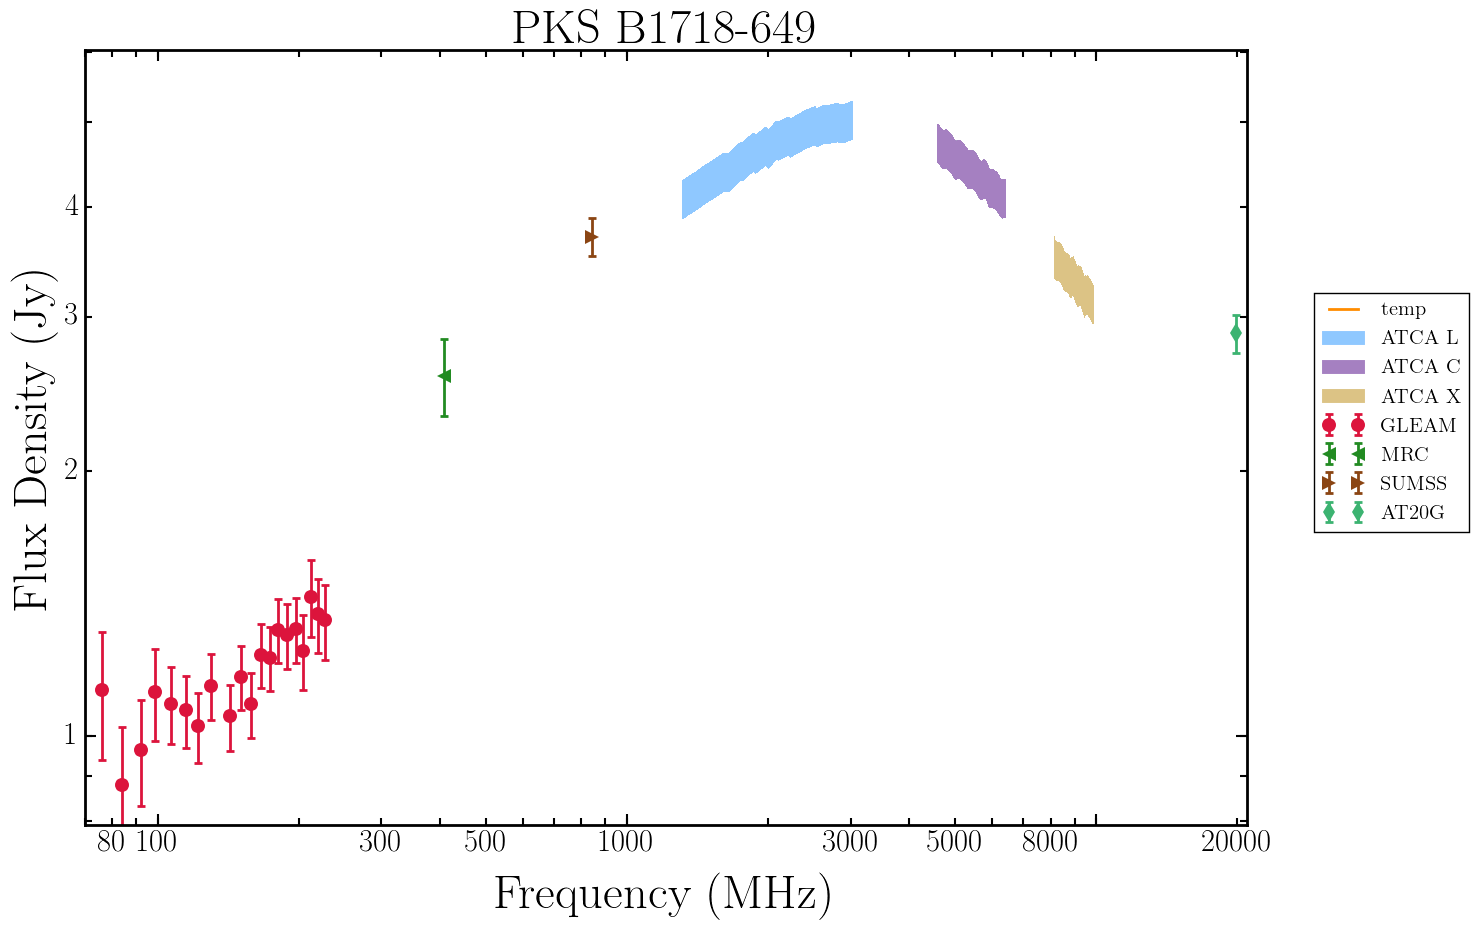

In [18]:
sed_df = pd.read_pickle(sed_loc)
temp = [i for i,s in enumerate(sed_df.name) if '1744' in s]
sed_df.loc[temp].freq
import importlib
importlib.reload(seds_plot_func)

i = 89
freq_arr = sed_df.loc[i]["freq"]*1000 # in MHz
flux_arr = sed_df.loc[i]["flux"]
flux_err_arr = sed_df.loc[i]["flux_err"]
name = sed_df.loc[i]["name"]
print(name)
name = 'PKS B1718-649'

n = 100
freq_arr, flux_arr, flux_err_arr = atca_filter(n, freq_arr, flux_arr, flux_err_arr)


# residuals = True
seds_plot_func.sed(powlaw,['temp'],[1,1],freq_arr,
                   flux_arr,flux_err_arr, name, 
                   freq_labels = True, savefig = False, resid=False)

plt.close()

In [8]:
sed_df

,best_model,flux,flux_err,freq,name
0,,"[2.6, 2.076, 0.609, 0.355, 0.166, 0.388, 0.646...","[0.26, 0.1038, 0.0609, 0.0355, 0.0083, 0.0194,...","[0.408, 0.843, 4.85, 8.64, 19.904001, 8.641001...",j212155-6404
1,,"[0.6089774, 0.6124203, 0.6093183, 0.6099247, 0...","[0.03044887, 0.030621015, 0.030465915, 0.03049...","[4.577, 4.578, 4.579, 4.58, 4.581, 4.582, 4.58...",j231326-5343
2,,"[0.7445449, 0.7408553, 0.7440639, 0.740356, 0....","[0.037227245, 0.037042765, 0.037203195, 0.0370...","[4.577, 4.578, 4.579, 4.58, 4.581, 4.582, 4.58...",j213801-4646
3,,"[1.629044, 1.632611, 1.6337, 1.636873, 1.62516...","[0.0814522, 0.08163055, 0.081685, 0.08184365, ...","[3.023, 3.022, 3.021, 3.02, 3.019, 3.018, 3.01...",2311-452
4,,"[0.9898838, 0.9900698, 0.9922408, 0.9912019, 0...","[0.04949419, 0.04950349, 0.04961204, 0.0495600...","[4.577, 4.578, 4.579, 4.58, 4.581, 4.582, 4.58...",j221438-3835
5,,"[1.241398, 1.231956, 1.225818, 1.229971, 1.234...","[0.0620699, 0.0615978, 0.0612909, 0.06149855, ...","[3.023, 3.022, 3.021, 3.02, 3.019, 3.018, 3.01...",pks2254-367
6,,"[0.3791716, 0.3700756, 0.3653891, 0.3680977, 0...","[0.01895858, 0.01850378, 0.018269455, 0.018404...","[3.023, 3.022, 3.021, 3.02, 3.019, 3.018, 3.01...",mwacsj2352.4-3316
7,,"[0.5419329, 0.5414525, 0.5390076, 0.5417374, 0...","[0.027096645, 0.027072625, 0.02695038, 0.02708...","[4.577, 4.578, 4.579, 4.58, 4.581, 4.582, 4.58...",j221942-2756
8,,"[1.013426, 1.011279, 1.01282, 1.014029, 1.0103...","[0.0506713, 0.05056395, 0.050641, 0.05070145, ...","[4.577, 4.578, 4.579, 4.58, 4.581, 4.582, 4.58...",j212921-1821
9,,"[0.3978571, 0.3975686, 0.3978745, 0.4008703, 0...","[0.019892855, 0.01987843, 0.019893725, 0.02004...","[4.577, 4.578, 4.579, 4.58, 4.581, 4.582, 4.58...",j225053-1204


# jey paper

In [1]:
import glob
texfiles = glob.glob('../survey_data/*.tex')
jey = []
for tex in texfiles: 
    try:
        df = pd.read_csv(tex,
                         sep='&',
                         header=None,
                         engine='python', names = ['Source', 'Sample',  'ID', 'z', 'LAS', 'Vpeakc', 'Speak', 'LS', 'log(Lpeak)', 'Refd'])

        jey.append([''.join(name.lower().strip().split('$')) for name in df.Source.tolist()])
    except:
        print(tex)
# flatten        
jey = [item for sublist in jey for item in sublist]

ra = []
dec = []
n=2
for j in jey:
    split =re.split(r'(\d+)', j)
    line = split[1]
    ra.append(':'.join([line[i:i+n] for i in range(0, len(line), n)])+':00')
    #ra.append(split[1]+'.00')
    line = split[3]
    dec.append(split[2]+':'.join([line[i:i+n] for i in range(0, len(line), n)])+':00')
    #dec.append(split[3]+'.00')
temp_df = pd.DataFrame(list(zip(jey, ra, dec)), columns=['name', 'RA', 'DEC'])
temp_df.to_csv('../survey_data/jey.csv')

../survey_data/table_css_nup.tex
../survey_data/table_css_nup1.tex
../survey_data/table_css_nup2.tex
../survey_data/table_gps_nup.tex


NameError: name 'pd' is not defined